In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# --- DATASET INITIALIZATION ---

candidate_registry = {
    'Candidate_UID': ['INT001', 'INT002', 'INT003', 'INT004', 'INT005', 'INT006', 'INT007', 'INT008', 'INT009', 'INT010'],
    'Full_Name': ['Alice Smith', 'Bob Johnson', 'Charlie Lee', 'Diana Brown', 'Eve Davis', 'Frank Wilson', 'Grace Kim', 'Henry Patel', 'Isabel Garcia', 'Jack Chen'],
    'Skill_Set': [
        'Python, Data Analysis, Excel, Basic Machine Learning, Pandas',
        'Java, SQL, Database Management, Basic Python, Git',
        'Python, Web Development, HTML, CSS, JavaScript, React',
        'R, Statistics, Data Visualization, Excel, Tableu',
        'Python, Basic Machine Learning, SQL, Tableau, Numpy',
        'Python, Django, PostgreSQL, REST API, Docker',
        'JavaScript, Node.js, MongoDB, Web Development, Express.js',
        'Python, Machine Learning, Scikit-learn, Data Analysis, Linux',
        'R, SQL, Power BI, Statistics, Data Cleaning',
        'C++, Python, Algorithms, Data Structures, Cloud Computing'
    ],
    'Skill_Competency': [
        'Intermediate, Intermediate, Advanced, Beginner, Intermediate',
        'Advanced, Intermediate, Intermediate, Beginner, Intermediate',
        'Intermediate, Advanced, Advanced, Intermediate, Intermediate, Beginner',
        'Advanced, Advanced, Intermediate, Advanced, Intermediate',
        'Intermediate, Beginner, Intermediate, Intermediate, Intermediate',
        'Advanced, Intermediate, Intermediate, Intermediate, Beginner',
        'Intermediate, Intermediate, Intermediate, Advanced, Intermediate',
        'Advanced, Intermediate, Advanced, Intermediate, Beginner',
        'Intermediate, Intermediate, Intermediate, Advanced, Intermediate',
        'Advanced, Intermediate, Advanced, Advanced, Beginner'
    ]
}

market_roles_registry = {
    'Position_ID': ['JOB001', 'JOB002', 'JOB003', 'JOB004', 'JOB005'],
    'Designation': ['Data Scientist', 'Software Engineer', 'Data Analyst', 'Machine Learning Engineer', 'Full Stack Developer'],
    'Target_Skills': [
        'Python, Machine Learning, Deep Learning, SQL, Data Visualization, Statistics, Big Data, TensorFlow',
        'Java, Python, JavaScript, Web Development, Database Management, Cloud Computing, Docker, Git',
        'Python, R, SQL, Excel, Data Visualization, Statistics, Tableu, Power BI',
        'Python, Machine Learning, Deep Learning, Scikit-learn, TensorFlow, PyTorch, Big Data, Linux',
        'JavaScript, React, Node.js, Python, Django, MongoDB, REST API, Cloud Computing'
    ],
    'Seniority_Target': ['Mid-Senior', 'Mid-Senior', 'Entry-Mid', 'Mid-Senior', 'Mid-Senior']
}

career_interest_mapping = {
    'Candidate_UID': [
        'INT001', 'INT001', 'INT002', 'INT002', 'INT003', 'INT003', 'INT004', 'INT004', 'INT005', 'INT005',
        'INT006', 'INT006', 'INT007', 'INT007', 'INT008', 'INT008', 'INT009', 'INT009', 'INT010', 'INT010'
    ],
    'Position_ID': [
        'JOB001', 'JOB003', 'JOB002', 'JOB003', 'JOB003', 'JOB005', 'JOB001', 'JOB003', 'JOB001', 'JOB003',
        'JOB004', 'JOB005', 'JOB005', 'JOB003', 'JOB001', 'JOB004', 'JOB003', 'JOB001', 'JOB002', 'JOB004'
    ]
}

In [4]:
df_candidates = pd.DataFrame(candidate_registry)
df_positions = pd.DataFrame(market_roles_registry)
df_interests = pd.DataFrame(career_interest_mapping)

# Standardize text data
df_candidates['Skill_Set'] = df_candidates['Skill_Set'].str.lower().str.split(', ')
df_candidates['Skill_Competency'] = df_candidates['Skill_Competency'].str.lower().str.split(', ')
df_positions['Target_Skills'] = df_positions['Target_Skills'].str.lower().str.split(', ')

# Validation Check
for i, entry in df_candidates.iterrows():
    if len(entry['Skill_Set']) != len(entry['Skill_Competency']):
        print(f"Error: Skill mismatch for {entry['Candidate_UID']}")
        exit()

# Map skills to their respective levels
df_candidates['Competency_Map'] = df_candidates.apply(
    lambda x: dict(zip(x['Skill_Set'], x['Skill_Competency'])), axis=1
)

In [5]:
# --- NLP & K-MEANS CLUSTERING ---

corpus = [' '.join(s) for s in df_candidates['Skill_Set']] + [' '.join(ts) for ts in df_positions['Target_Skills']]
text_vectorizer = TfidfVectorizer()
vectorized_matrix = text_vectorizer.fit_transform(corpus)

candidate_vectors = vectorized_matrix[:len(df_candidates)]
position_vectors = vectorized_matrix[len(df_candidates):]

print("\n--- Feature Vocabulary ---")
display(pd.DataFrame(text_vectorizer.get_feature_names_out(), columns=['Extracted Skill']).style.set_properties(**{'text-align': 'center'}))

# Perform Clustering
cluster_count = 3
grouping_engine = KMeans(n_clusters=cluster_count, random_state=42)
df_candidates['Talent_Cluster'] = grouping_engine.fit_predict(candidate_vectors)

print("\n--- Talent Grouping Summary ---")
group_log = []
for cluster_id in range(cluster_count):
    subset = df_candidates[df_candidates['Talent_Cluster'] == cluster_id]
    for _, row in subset.iterrows():
        group_log.append({
            'Cluster': cluster_id,
            'ID': row['Candidate_UID'],
            'Name': row['Full_Name'],
            'Skills': ', '.join(row['Skill_Set'])
        })
display(pd.DataFrame(group_log).style.set_properties(**{'text-align': 'center'}))


--- Feature Vocabulary ---


,Extracted Skill
0,algorithms
1,analysis
2,api
3,basic
4,bi
5,big
6,cleaning
7,cloud
8,computing
9,css



--- Talent Grouping Summary ---


,Cluster,ID,Name,Skills
0,0,INT004,Diana Brown,"r, statistics, data visualization, excel, tableu"
1,0,INT007,Grace Kim,"javascript, node.js, mongodb, web development, express.js"
2,0,INT009,Isabel Garcia,"r, sql, power bi, statistics, data cleaning"
3,1,INT001,Alice Smith,"python, data analysis, excel, basic machine learning, pandas"
4,1,INT008,Henry Patel,"python, machine learning, scikit-learn, data analysis, linux"
5,1,INT010,Jack Chen,"c++, python, algorithms, data structures, cloud computing"
6,2,INT002,Bob Johnson,"java, sql, database management, basic python, git"
7,2,INT003,Charlie Lee,"python, web development, html, css, javascript, react"
8,2,INT005,Eve Davis,"python, basic machine learning, sql, tableau, numpy"
9,2,INT006,Frank Wilson,"python, django, postgresql, rest api, docker"



--- Final Discrepancy Report ---


,Candidate,Target_Role,Missing,Action_Plan
0,Alice Smith,Data Scientist,"machine learning, deep learning, sql, data visualization, statistics, big data, tensorflow","Acquire skills in: machine learning, deep learning, sql, data visualization, statistics, big data, tensorflow"
1,Alice Smith,Data Analyst,"r, sql, data visualization, statistics, tableu, power bi","Acquire skills in: r, sql, data visualization, statistics, tableu, power bi"
2,Bob Johnson,Software Engineer,"python, javascript, web development, cloud computing, docker","Acquire skills in: python, javascript, web development, cloud computing, docker"
3,Bob Johnson,Data Analyst,"python, r, excel, data visualization, statistics, tableu, power bi","Acquire skills in: python, r, excel, data visualization, statistics, tableu, power bi"
4,Charlie Lee,Data Analyst,"r, sql, excel, data visualization, statistics, tableu, power bi","Acquire skills in: r, sql, excel, data visualization, statistics, tableu, power bi"
5,Charlie Lee,Full Stack Developer,"react, node.js, django, mongodb, rest api, cloud computing","Acquire skills in: react, node.js, django, mongodb, rest api, cloud computing"
6,Diana Brown,Data Scientist,"python, machine learning, deep learning, sql, big data, tensorflow","Acquire skills in: python, machine learning, deep learning, sql, big data, tensorflow"
7,Diana Brown,Data Analyst,"python, sql, power bi","Acquire skills in: python, sql, power bi"
8,Eve Davis,Data Scientist,"machine learning, deep learning, data visualization, statistics, big data, tensorflow","Acquire skills in: machine learning, deep learning, data visualization, statistics, big data, tensorflow"
9,Eve Davis,Data Analyst,"r, excel, data visualization, statistics, tableu, power bi","Acquire skills in: r, excel, data visualization, statistics, tableu, power bi"


/tmp/ipython-input-2978746622.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Talent_Cluster', data=df_candidates, palette='magma')


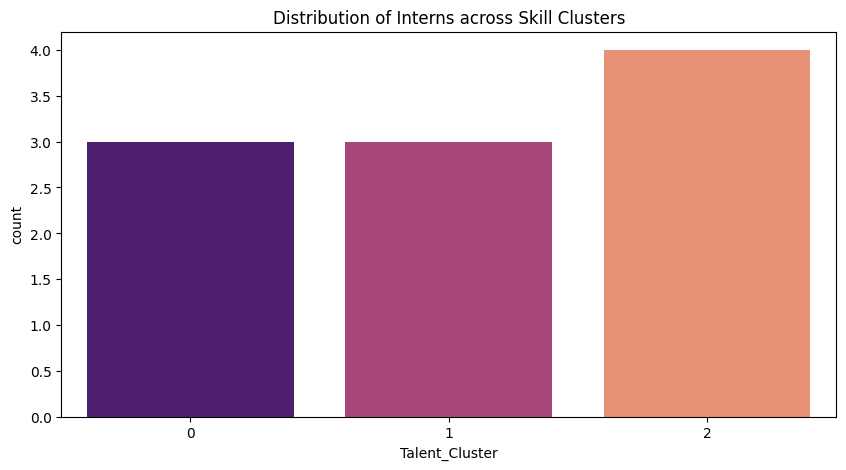

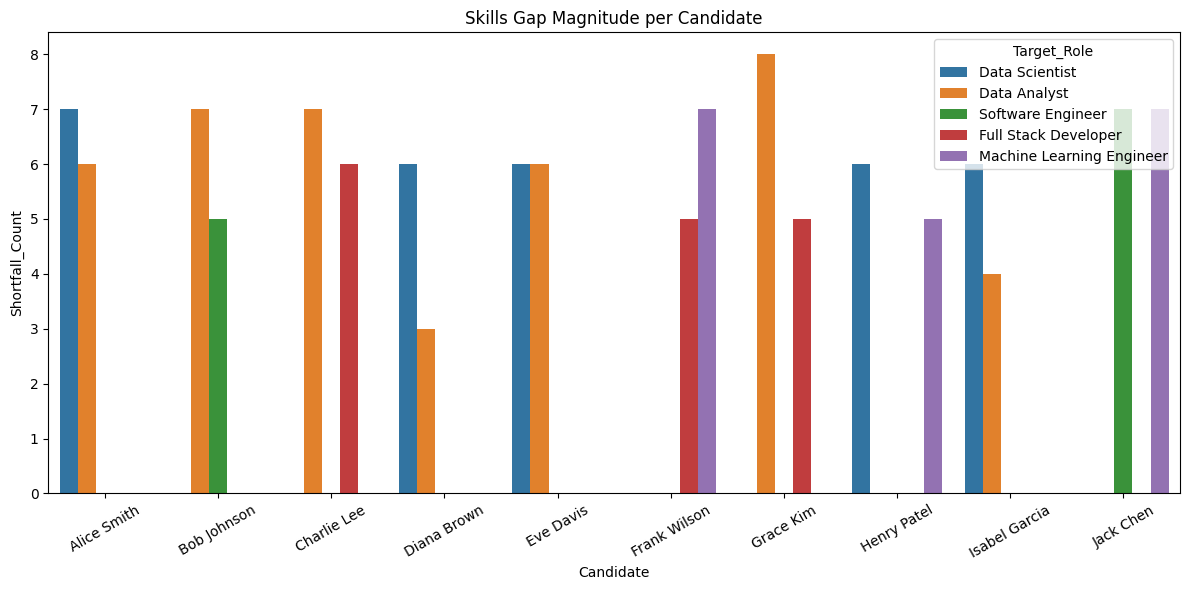

In [6]:
# --- SKILL GAP ANALYSIS ---

discrepancy_report = []
scoring_key = {'beginner': 1, 'intermediate': 2, 'advanced': 3}
THRESHOLD = scoring_key['intermediate']

for _, cand in df_candidates.iterrows():
    selection = df_interests[df_interests['Candidate_UID'] == cand['Candidate_UID']]
    for _, pos in df_positions.iterrows():
        if pos['Position_ID'] in selection['Position_ID'].values:
            # Only count skills where user is at least 'intermediate'
            verified_skills = [
                s for s, level in cand['Competency_Map'].items()
                if scoring_key.get(level, 1) >= THRESHOLD
            ]
            shortfall = [s for s in pos['Target_Skills'] if s not in verified_skills]

            discrepancy_report.append({
                'Candidate': cand['Full_Name'],
                'Target_Role': pos['Designation'],
                'Missing': ', '.join(shortfall) if shortfall else 'None',
                'Action_Plan': f"Acquire skills in: {', '.join(shortfall)}" if shortfall else 'Optimal match'
            })

df_report = pd.DataFrame(discrepancy_report)

print("\n--- Final Discrepancy Report ---")
display(df_report.style.set_properties(**{'text-align': 'center'}))

# --- VISUALIZATION ---

plt.figure(figsize=(10, 5))
sns.countplot(x='Talent_Cluster', data=df_candidates, palette='magma')
plt.title('Distribution of Interns across Skill Clusters')
plt.show()

df_report['Shortfall_Count'] = df_report['Missing'].apply(lambda x: len(x.split(', ')) if x != 'None' else 0)
plt.figure(figsize=(12, 6))
sns.barplot(x='Candidate', y='Shortfall_Count', hue='Target_Role', data=df_report)
plt.xticks(rotation=30)
plt.title('Skills Gap Magnitude per Candidate')
plt.tight_layout()
plt.show()

df_report.to_csv('intern_talent_analysis.csv', index=False)